This code is made by Chas (and AlexR) and was modified for python3

In [1]:
import numpy as np
import pickle as pickle
import scipy.interpolate as interp
import scipy.signal as signal
import scipy.optimize as opti
import scipy, sys, time
import matplotlib.pyplot as plt
from matplotlib.mlab import psd


In [84]:
# bead radius [µm] (certain it shouldn't be diameter)
rbead = 2.4e-6 #float(sys.argv[1])
# separation attractor [µm] - to surface of the bead
sep = 15e-6 #float(sys.argv[2])
# difference in height of attractor and bead [µm]
height = 0 #float(sys.argv[3])

# load the density profile of the attractor (took the one AlexR and Chas have produced)
rhopath = '/home/analysis_user/New_trap_code/SensitivityFramework/results/rho_arr.p'
rho, xx, yy, zz = pickle.load(open(rhopath, 'rb'), encoding="latin1") # first change, encoding to latin1 instead of ASCII
print("Density Loaded.")
sys.stdout.flush()

Density Loaded.


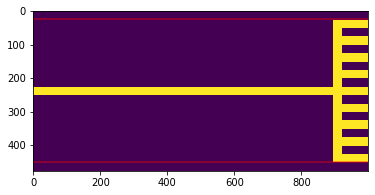

In [85]:
plt.imshow(rho[11:488,0:1000,int(.5*len(zz))])
plt.axhline(25,color="Red",alpha=0.5)
plt.axhline(450,color="Red",alpha=0.5)

In [87]:
xx = np.array(xx) # maxe array for x
yy = np.array(yy) # make array for y
zz = np.array(zz) # make array for z

xinds = np.abs(xx) <= 25.0e-6 #
yinds = np.abs(yy) <= 80.0e-6 #
zinds = np.abs(zz) <= 5.0e-6 #

xx2 = xx[xinds] #
yy2 = yy[yinds] #
zz2 = zz[zinds] #
rho2 = rho[xinds,:,:][:,yinds,:] #


# produce empty arrays 

xzeros = np.zeros(len(xx))
yzeros = np.zeros(len(yy))
zzeros = np.zeros(len(zz))

xzeros2 = np.zeros(len(xx2))
yzeros2 = np.zeros(len(yy2))
zzeros2 = np.zeros(len(zz2))

dx = np.abs(xx[1] - xx[0])
dy = np.abs(yy[1] - yy[0])
dz = np.abs(zz[1] - zz[0])

cell_volume = dx * dy * dz
m = rho * cell_volume
m2 = rho2 * cell_volume

In [88]:

G = 6.67e-11     # m^3 / (kg s^2)
rhobead = 1550.

travel = 500e-6 # travel
cent = 0.0e-6 # where to start
Npoints = 1001 # how many points for each direction
beadposvec = np.linspace(cent - travel*0.5, cent + travel*0.5, Npoints)
beadposvec2 = np.linspace(-1.0 * travel, travel, 2*(Npoints-1) + 1)

lambdas = np.logspace(-6.3, -3, 100)
lambdas = lambdas[::-1]

In [89]:
len(beadposvec2)

2001

In [90]:
# where to put the results and how to name them

respath = '/home/analysis_user/Results/Sensitivity/'
respath = respath + 'rbead_' + str(rbead)
respath = respath + '_sep_' + str(sep)
respath = respath + '_height_' + str(height)
respath = respath + '.p'
results_dic = {}
results_dic['order'] = 'Rbead, Sep, Height, Yuklambda'



finger_inds = np.array([-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0])


In [91]:
def find_ind(pos):
    if np.abs(pos) <= 25e-6:
        ind = 0
    elif np.abs(pos) > 25e-6:
        if np.abs(pos) <= 75e-6:
            if pos > 0:
                ind = 1.0
            elif pos < 0:
                ind = -1.0
        elif np.abs(pos) > 75e-6:
            if np.abs(pos) <= 125e-6:
                if pos > 0:
                    ind = 2.0
                if pos < 0:
                    ind = -2.0
            elif np.abs(pos) > 125e-6:
                if np.abs(pos) <= 175e-6:
                    if pos > 0:
                        ind = 3.0
                    if pos < 0:
                        ind = -3.0
                elif np.abs(pos) > 175e-6:
                    if pos > 0:
                        ind = 4.0
                    if pos < 0:
                        ind = -4.0

    newpos = pos - ind * 50e-6

    return ind, newpos


def dist(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)

def dist_p_arrp(p1, xs, ys, zs):
    xnew = (xs - p1[0])**2
    ynew = (ys - p1[1])**2
    znew = (zs - p1[2])**2
    return np.sqrt(np.add.outer(np.add.outer(xnew, ynew), znew))

In [92]:
results_dic[rbead] = {}
results_dic[rbead][sep] = {}
results_dic[rbead][sep][height] = {}


Gterm = 2. * rbead**3

GforcecurveX = []
GforcecurveY = []
GforcecurveZ = []

In [93]:
for ind, xpos in enumerate(beadposvec2):
    beadpos = [xpos, sep+rbead, height]

    s = dist_p_arrp(beadpos, xx2, yy2, zz2) - rbead
    # These are used to compute projections and thus need to maintain sign
    xsep = dist_p_arrp([xpos, 0, 0], xx2, yzeros2, zzeros2)
    xind = np.argmin(np.abs(xx2 - xpos))
    xsep[:xind,:,:] *= -1.0

    # We a priori know that all yseps should be negative
    ysep = dist_p_arrp([0, sep+rbead, 0], xzeros2, yy2, zzeros2)
    ysep *= -1.0

    zsep = dist_p_arrp([0, 0, height], xzeros2, yzeros2, zz2)
    zind = np.argmin(np.abs(zz2 - height))
    zsep[:,:,:zind] *= -1.0
    print(zsep[0,0,0])    

    
    xprojection = xsep / (s + rbead)
    yprojection = ysep / (s + rbead)
    zprojection = zsep / (s + rbead)

    prefac = ((2. * G * m2 * rhobead * np.pi) / (3. * (rbead + s)**2))

    xtotforce = np.sum(prefac * Gterm * xprojection)
    ytotforce = np.sum(prefac * Gterm * yprojection)
    ztotforce = np.sum(prefac * Gterm * zprojection)

    # SWAP X AND Y AXES TO MATCH DATA AXES
    GforcecurveX.append(ytotforce)
    GforcecurveY.append(xtotforce)
    GforcecurveZ.append(ztotforce)

GforcecurveX = np.array(GforcecurveX)
GforcecurveY = np.array(GforcecurveY)
GforcecurveZ = np.array(GforcecurveZ)
plt.plot(GforcecurveY)
GX = interp.interp1d(beadposvec2, GforcecurveX, kind='cubic')
GY = interp.interp1d(beadposvec2, GforcecurveY, kind='cubic')
GZ = interp.interp1d(beadposvec2, GforcecurveZ, kind='cubic')
newGX = np.zeros(len(beadposvec))
newGY = np.zeros(len(beadposvec))
newGZ = np.zeros(len(beadposvec))

for ind, pos in enumerate(beadposvec):
    if np.abs(pos) - 225e-6 > 0:
        newGX[ind] = 0.0
        newGY[ind] = 0.0
        newGZ[ind] = 0.0
        continue

    finger_ind, newpos = find_ind(pos)
    width = 50.0e-6

    newGX[ind] = np.sum(GX(newpos + (finger_inds+finger_ind) * width))
    newGY[ind] = np.sum(GY(newpos + (finger_inds+finger_ind) * width))
    newGZ[ind] = np.sum(GZ(newpos + (finger_inds+finger_ind) * width))  

print('Computed normal grav')
sys.stdout.flush()

ValueError: attempt to get argmin of an empty sequence

In [94]:
for yukind, yuklambda in enumerate(lambdas):
    per = int(100. * float(yukind) / float(len(lambdas)))
    if not per % 1:
        print(str(per) + ',',)
    sys.stdout.flush()

    func = np.exp(-2. * rbead / yuklambda) * (1. + rbead / yuklambda) + rbead / yuklambda - 1.

    yukforcecurveX = []
    yukforcecurveY = []
    yukforcecurveZ = []
    for ind, xpos in enumerate(beadposvec2):

        beadpos = [xpos, sep+rbead, height]

        s = dist_p_arrp(beadpos, xx2, yy2, zz2) - rbead
        # These are used to compute projections and thus need to maintain sign
        xsep = dist_p_arrp([xpos, 0, 0], xx2, yzeros2, zzeros2)
        xind = np.argmin(np.abs(xx2 - xpos))
        xsep[:xind,:,:] *= -1.0

        # We a priori know that all yseps should be negative
        ysep = dist_p_arrp([0, sep+rbead, 0], xzeros2, yy2, zzeros2)
        ysep *= -1.0

        zsep = dist_p_arrp([0, 0, height], xzeros2, yzeros2, zz2)
        zind = np.argmin(np.abs(zz2 - height))
        zsep[:,:,:zind] *= -1.0
            
        xprojection = xsep / (s + rbead)
        yprojection = ysep / (s + rbead)
        zprojection = zsep / (s + rbead)

        prefac = ((2. * G * m2 * rhobead * np.pi) / (3. * (rbead + s)**2))

        yukterm = 3 * yuklambda**2 * (rbead + s + yuklambda) * func * np.exp( - s / yuklambda )
        #print(-s/yuklambda)
        xtotforce = np.sum(prefac * yukterm * xprojection)
        ytotforce = np.sum(prefac * yukterm * yprojection)
        ztotforce = np.sum(prefac * yukterm * zprojection)
      

        # SWAP X AND Y AXES TO MATCH DATA AXES
        yukforcecurveX.append(ytotforce) 
        yukforcecurveY.append(xtotforce)
        yukforcecurveZ.append(ztotforce)
        
    yukforcecurveX = np.array(yukforcecurveX)
    yukforcecurveY = np.array(yukforcecurveY)
    yukforcecurveZ = np.array(yukforcecurveZ)

    yukX = interp.interp1d(beadposvec2, yukforcecurveX, kind='cubic')
    yukY = interp.interp1d(beadposvec2, yukforcecurveY, kind='cubic')
    yukZ = interp.interp1d(beadposvec2, yukforcecurveZ, kind='cubic')

    newyukX = np.zeros(len(beadposvec))
    newyukY = np.zeros(len(beadposvec))
    newyukZ = np.zeros(len(beadposvec))

    for ind, pos in enumerate(beadposvec):
        if np.abs(pos) - 225e-6 > 0:
            newyukX[ind] = 0.0
            newyukY[ind] = 0.0
            newyukZ[ind] = 0.0
            continue

        finger_ind, newpos = find_ind(pos)
        width = 50.0e-6
  
        newyukX[ind] = np.sum(yukX(newpos + (finger_inds+finger_ind) * width))
        newyukY[ind] = np.sum(yukY(newpos + (finger_inds+finger_ind) * width))
        newyukZ[ind] = np.sum(yukZ(newpos + (finger_inds+finger_ind) * width))
        #print(newyukX[ind],newyukY[ind],newyukZ[ind])


    results_dic[rbead][sep][height][yuklambda] = \
                (newGX, newGY, newGZ, newyukX, newyukY, newyukZ)





print("100! Done!")

0,


ValueError: attempt to get argmin of an empty sequence

In [51]:
results_dic['posvec'] = beadposvec
try:
    pickle.dump(results_dic, open(respath, 'wb') )
    print("Saved: ", respath)
except:
    print("Save didn't work!")


Save didn't work!


In [52]:
test2 = results_dic[2.4e-06][1.5e-5][0][1e-5]

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


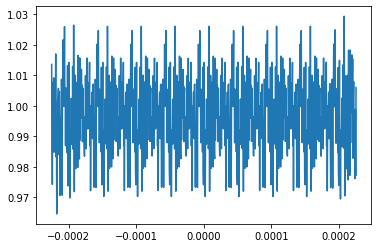

In [56]:
plt.plot(results_dic['posvec'],test[5]/test2[5])

In [121]:
print(respath)

/home/analysis_user/Results/Sensitivity/rbead_2.4e-06_sep_1.5e-05_height_0.p


In [23]:
results_dic

{2.4e-06: {1.5e-05: {0: {5.011872336272725e-07: (array([0., 0., 0., ..., 0., 0., 0.]),
     array([0., 0., 0., ..., 0., 0., 0.]),
     array([0., 0., 0., ..., 0., 0., 0.]),
     array([0., 0., 0., ..., 0., 0., 0.]),
     array([0., 0., 0., ..., 0., 0., 0.]),
     array([0., 0., 0., ..., 0., 0., 0.])),
    5.411695265464637e-07: (array([0., 0., 0., ..., 0., 0., 0.]),
     array([0., 0., 0., ..., 0., 0., 0.]),
     array([0., 0., 0., ..., 0., 0., 0.]),
     array([0., 0., 0., ..., 0., 0., 0.]),
     array([0., 0., 0., ..., 0., 0., 0.]),
     array([0., 0., 0., ..., 0., 0., 0.])),
    5.843414133735175e-07: (array([0., 0., 0., ..., 0., 0., 0.]),
     array([0., 0., 0., ..., 0., 0., 0.]),
     array([0., 0., 0., ..., 0., 0., 0.]),
     array([0., 0., 0., ..., 0., 0., 0.]),
     array([0., 0., 0., ..., 0., 0., 0.]),
     array([0., 0., 0., ..., 0., 0., 0.])),
    6.30957344480193e-07: (array([0., 0., 0., ..., 0., 0., 0.]),
     array([0., 0., 0., ..., 0., 0., 0.]),
     array([0., 0., 0., .

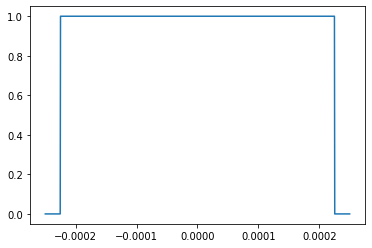

In [177]:
plt.plot(results_dic['posvec'],np.divide(results_dic[2.4e-06][1.5e-5][0][1e-5][0],(test[0]+1e-31)))